## Contextual Multi-Armed Bandit Demo (LinUCB)

This notebook creates a dummy contextual bandit dataset and then runs a simple LinUCB contextual multi-armed bandit on it, comparing performance against a random policy.
You can use this as a starting point and later plug in your own real dataset or more advanced bandit algorithms.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Problem configuration
N_ARMS = 3          # number of arms
N_FEATURES = 5      # context dimension
N_ROUNDS = 1000     # number of bandit rounds


In [19]:
# Step 1: True underlying parameters for each arm (N_ARMS x N_FEATURES)
true_thetas = np.random.randn(N_ARMS, N_FEATURES)
true_thetas

array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337],
       [-0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783]])

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Step 2: Generate contexts and reward probabilities
contexts = np.random.randn(N_ROUNDS, N_FEATURES)

# prob_matrix[t, a] = P(reward = 1 | context_t, arm=a)
logits = contexts @ true_thetas.T  # (N_ROUNDS x N_ARMS)
prob_matrix = sigmoid(logits)

# Step 3: Put into a DataFrame for inspection / possible saving
columns = [f'x{i}' for i in range(N_FEATURES)]
df = pd.DataFrame(contexts, columns=columns)
for a in range(N_ARMS):
    df[f'p_arm{a}'] = prob_matrix[:, a]

df.head()

,x0,x1,x2,x3,x4,p_arm0,p_arm1,p_arm2
0,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,0.271312,0.172698,0.993185
1,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.224523,0.431836,0.957190
2,0.110923,-1.150994,0.375698,-0.600639,-0.291694,0.403978,0.192851,0.902726
3,-0.601707,1.852278,-0.013497,-1.057711,0.822545,0.085704,0.981988,0.504447
4,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0.018460,0.460613,0.899885


In [21]:
df.shape

(1000, 8)

In [22]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,x0,x1,x2,x3,x4,p_arm0,p_arm1,p_arm2
x0,1.000000,-0.019328,0.058952,-0.010440,0.013732,0.291557,-0.107980,-0.158995
x1,-0.019328,1.000000,-0.007988,-0.025881,0.007610,-0.102842,0.812683,-0.164780
x2,0.058952,-0.007988,1.000000,-0.001450,-0.001419,0.372706,0.378996,0.083747
x3,-0.010440,-0.025881,-0.001450,1.000000,-0.017503,0.838610,-0.244557,-0.663124
x4,0.013732,0.007610,-0.001419,-0.017503,1.000000,-0.143372,0.261160,-0.614297
p_arm0,0.291557,-0.102842,0.372706,0.838610,-0.143372,1.000000,-0.190696,-0.485575
p_arm1,-0.107980,0.812683,0.378996,-0.244557,0.261160,-0.190696,1.000000,-0.093094
p_arm2,-0.158995,-0.164780,0.083747,-0.663124,-0.614297,-0.485575,-0.093094,1.000000


## Define an oracle policy (for regret computation)

The oracle always picks the arm with the highest true reward probability given the context. We will use this as a benchmark to compute regret.

In [23]:
# Oracle: best arm index and best expected reward per round
oracle_best_arm = prob_matrix.argmax(axis=1)
oracle_best_prob = prob_matrix.max(axis=1)

oracle_best_arm[:10], oracle_best_prob[:10]

(array([2, 2, 2, 1, 2, 2, 2, 0, 0, 2]),
 array([0.99318457, 0.95719042, 0.90272633, 0.98198751, 0.8998846 ,
        0.93562036, 0.9603637 , 0.61443061, 0.65800973, 0.71666359]))

## Implement LinUCB

We implement the classic **LinUCB** algorithm:

- For each arm `a`, maintain:
  - $A_a$ (d×d matrix, starts as identity)
  - $b_a$ (d×1 vector, starts as zeros)
- At each round with context $x_t$:
  1. For each arm, compute
     theta_hat_a = A_a^{-1} b_a$$
     p_{t,a} = \hat{\theta}_a^T x_t + \alpha \sqrt{x_t^T A_a^{-1} x_t}$$
  2. Choose arm with max $p_{t,a}$.
  3. Observe reward and update that arm's $A_a$ and $b_a$.


In [24]:
def run_linucb(alpha=1.0):
    d = N_FEATURES
    A = [np.eye(d) for _ in range(N_ARMS)]  # A_a matrices
    b = [np.zeros(d) for _ in range(N_ARMS)]  # b_a vectors

    chosen_arms = []
    rewards = []
    regrets = []

    for t in range(N_ROUNDS):
        x = contexts[t]  # context vector

        # Compute UCB scores for each arm
        p_t = []
        for a in range(N_ARMS):
            A_inv = np.linalg.inv(A[a])
            theta_hat = A_inv @ b[a]
            x_col = x.reshape(-1, 1)
            mu_hat = theta_hat @ x
            # exploration bonus
            s = np.sqrt((x_col.T @ A_inv @ x_col)[0, 0])
            p = mu_hat + alpha * s
            p_t.append(p)

        chosen_arm = int(np.argmax(p_t))
        chosen_arms.append(chosen_arm)

        p_true = prob_matrix[t, chosen_arm]
        reward = np.random.binomial(1, p_true)
        rewards.append(reward)

        # Compute instantaneous regret vs oracle
        regret = oracle_best_prob[t] - p_true
        regrets.append(regret)

        # Update parameters for chosen arm
        A[chosen_arm] += np.outer(x, x)
        b[chosen_arm] += reward * x

    return {
        'chosen_arms': np.array(chosen_arms),
        'rewards': np.array(rewards),
        'regrets': np.array(regrets)
    }

# Quick test run
linucb_results = run_linucb(alpha=1.0)
linucb_results['rewards'][:10], linucb_results['chosen_arms'][:10]

(array([1, 1, 0, 1, 0, 0, 1, 0, 1, 0]), array([0, 0, 0, 1, 0, 0, 2, 1, 0, 1]))

## Random policy baseline

Whether LinUCB is actually learning something useful, we compare it against a random policy that picks a random arm at each round.

In [25]:
def run_random_policy():
    chosen_arms = []
    rewards = []
    regrets = []

    for t in range(N_ROUNDS):
        chosen_arm = np.random.randint(N_ARMS)
        chosen_arms.append(chosen_arm)

        p_true = prob_matrix[t, chosen_arm]
        reward = np.random.binomial(1, p_true)
        rewards.append(reward)

        regret = oracle_best_prob[t] - p_true
        regrets.append(regret)

    return {
        'chosen_arms': np.array(chosen_arms),
        'rewards': np.array(rewards),
        'regrets': np.array(regrets)
    }

random_results = run_random_policy()
random_results['rewards'][:10], random_results['chosen_arms'][:10]

(array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1]), array([1, 2, 0, 2, 0, 2, 0, 0, 0, 2]))

## Compare LinUCB vs Random: cumulative reward & regret

We now plot:
- **Cumulative reward** over time for both policies.
- **Cumulative regret** over time.

LinUCB outperform the random policy as it learns which arms are better in which contexts.

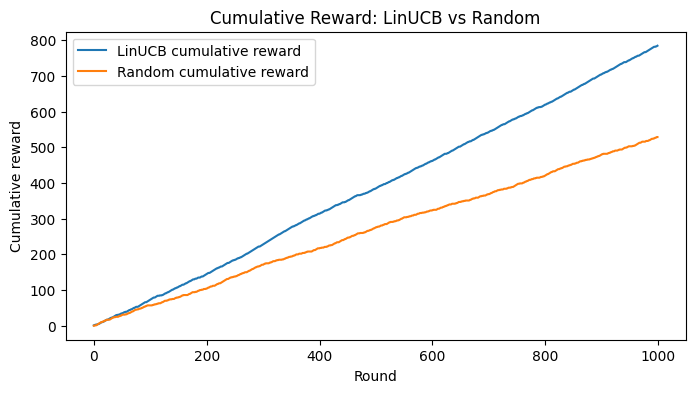

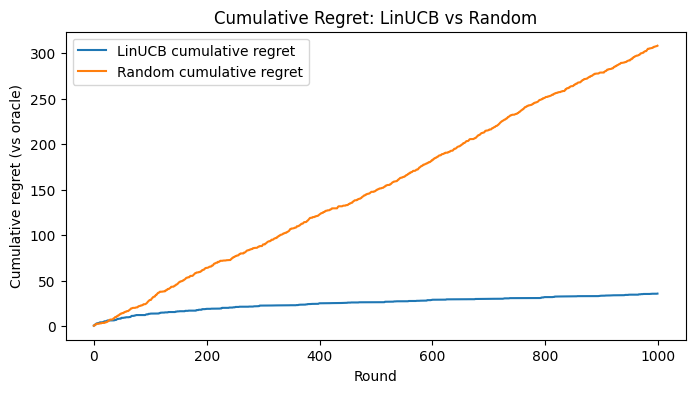

In [26]:
lin_cum_reward = np.cumsum(linucb_results['rewards'])
rnd_cum_reward = np.cumsum(random_results['rewards'])

lin_cum_regret = np.cumsum(linucb_results['regrets'])
rnd_cum_regret = np.cumsum(random_results['regrets'])

plt.figure(figsize=(8, 4))
plt.plot(lin_cum_reward, label='LinUCB cumulative reward')
plt.plot(rnd_cum_reward, label='Random cumulative reward')
plt.xlabel('Round')
plt.ylabel('Cumulative reward')
plt.legend()
plt.title('Cumulative Reward: LinUCB vs Random')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(lin_cum_regret, label='LinUCB cumulative regret')
plt.plot(rnd_cum_regret, label='Random cumulative regret')
plt.xlabel('Round')
plt.ylabel('Cumulative regret (vs oracle)')
plt.legend()
plt.title('Cumulative Regret: LinUCB vs Random')
plt.show()

## Quick summary statistics

Printing some simple summary stats to see the final performance numbers.

In [27]:
print('--- LinUCB ---')
print('Total reward:', lin_cum_reward[-1])
print('Average reward:', lin_cum_reward[-1] / N_ROUNDS)
print('Total regret:', lin_cum_regret[-1])

print('\n--- Random Policy ---')
print('Total reward:', rnd_cum_reward[-1])
print('Average reward:', rnd_cum_reward[-1] / N_ROUNDS)
print('Total regret:', rnd_cum_regret[-1])

--- LinUCB ---
Total reward: 785
Average reward: 0.785
Total regret: 36.01524504234524

--- Random Policy ---
Total reward: 529
Average reward: 0.529
Total regret: 308.3258867789594
